# MA5851 Data Science Masterclass 1
### Assignment 3: Webcrawler and NLP System
### Laura Vodden

# Document 2. Twitter Scraper using Selenium
####   
##  Rationale
### There is a gender imbalance in STEM careers (ref).  Such an imbalance should show up as bias in language data and this bias should therefore appear and may even amplify in any predictions made based on language data (Sun et al. 2019). 
### For this analysis, Twitter is the sole website from which data were extracted. This is because tweets provide a large number and wide range of language data relating to any conceivable topic. It is possible to scrape data from Twitter using specific search terms, allowing targeted collection of information and ensuring collected data are relevant to this investigation.

### The reason for extracting web content from Twitter is that Twitter behaves as a largely uncensored (with exceptions), global-scale historical record from the perspective of everyday members of society, not just the powerful and privileged, as has been the case in the past (although, importantly, and in line with the topic of this report, Tweets written by people of colour are more likely to be flagged as offensive and removed by machine learning algorithms (Wei, 2020)). In 2020, 500 million tweets were published daily. Users from around the world post their uninhibited thoughts and feelings about all kinds of topics, and so Twitter can be treated as a repository of people’s opinions and attitudes, and therefore their personal biases, and on a grander scale, the biases of society, through time. This makes Twitter an ideal source of data for sentiment analysis and natural language processing in general (ref). Because this investigation seeks to research implicit gender bias in STEM-related topics, and because gender bias is a social issue, it is sensible to look for data where people produce a high volume of text relating to, in this case, STEM careers. 

### For this analysis, Twitter, data covers tweets containing hashtags relating to STEM (science/scientist, technology/technologist, engineering/engineer, and math/mathematics/mathematician), which also contain the gender pronouns (she/her/hers, he/him/his). For the purpose of this research, only these two binary genders are incorporated because…. The resulting dataframe comprised xx,xxx records of STEM-related tweets from April 14, 2021. The number of STEM tweets containing female pronouns vs male pronouns was investigated.
####  
####  
## Methods
### Webscraper
### The data from Twitter were complicated to extract – why?. Due to the perpetual scrolling nature of the site, it was decided that the best way to scrape Tweet data would be using the Selenium package. Selenium works by automating web browser activity, replicating functions such as open, click and scroll (ref). The package requires installation of a driver to interface with a browser (Chrome was used here).

### Selenium was used to open, navigate and enter a search term to scrape Tweet data while scrolling downwards, allowing new Tweets to appear. The xpath function was used to select specific data (Tweet, User, Date) from the HTML inspect navigation panel.

### Tweets containing the specified search terms were extracted straight into several columns: Tweet, STEM hashtags, gender pronouns. From here, information was extracted from Tweets. Sentiment analysis was performed on each tweet to determine popular sentiment towards women in STEM.


In [2]:
import pandas as pd
import numpy as np
from getpass import getpass
from time import sleep
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
from webdriver_manager.chrome import ChromeDriverManager
import csv
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt

In [2]:
# Function to scrape Twitter using Selenium

def get_tweet_data(card):
    #Extract tweet data
    #username
    try:
        username = card.find_element_by_xpath('.//span').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #twitter handle
    try:
        handle = card.find_element_by_xpath('.//span[contains(text(), "@")]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #tweet text
    try:
        comment = card.find_element_by_xpath('.//div[2]/div[2]/div[1]').text
        responding = card.find_element_by_xpath('.//div[2]/div[2]/div[2]').text
        text = comment+responding
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #reply count
    try:
        comment = card.find_element_by_xpath('//div[@data-testid="reply"]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #retweet count
    try:
        retweet = card.find_element_by_xpath('//div[@data-testid="retweet"]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #likes
    try:
        like = card.find_element_by_xpath('//div[@data-testid="like"]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    try:
        #post date
        date = card.find_element_by_xpath('.//time').get_attribute('datetime')
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    
    tweet = (username, handle, text, comment, retweet, like, date)
    return tweet 

# create instance of webdriver
driver = webdriver.Chrome()
driver.get('https://www.twitter.com/login')


In [3]:
#navigate to twitter and login
username = driver.find_element_by_xpath('//input[@name="session[username_or_email]"]')
username.send_keys('laura.vodden@outlook.com')
mypassword = getpass()

password = driver.find_element_by_xpath('//input[@name="session[password]"]')
password.send_keys(mypassword)
password.send_keys(Keys.RETURN)


········


In [5]:
#find search input and search for term

#navigte to 'explore' tab
driver.find_element_by_xpath('//a[@data-testid="AppTabBar_Explore_Link"]').click()

search_input = driver.find_element_by_xpath('//input[@aria-label="Search query"]')
search_input.send_keys('(science OR technology OR engineering OR math OR mathematics OR scientist OR technologist OR engineer OR mathematician) (she OR her OR he OR him) -filter:retweets')
search_input.send_keys(Keys.RETURN)

#navigte to 'latest' tab
driver.find_element_by_link_text('Latest').click()

# get all tweets on the page
data = []
tweet_ids = set()
last_position = driver.execute_script("return window.pageYOffset;")
scrolling = True

while scrolling:
    page_cards = driver.find_elements_by_xpath('//div[@data-testid="tweet"]')
    for card in page_cards[-15:]:
        tweet = get_tweet_data(card)
        if tweet:
            tweet_id = ''.join(tweet)
            if tweet_id not in tweet_ids:
                tweet_ids.add(tweet_id)
            data.append(tweet)
    
    scroll_attempt = 0
    while True:
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        sleep(1)
        curr_position = driver.execute_script("return window.pageYOffset;")
        if last_position == curr_position:
            scroll_attempt += 1
            
            #end of scroll region
            if scroll_attempt >= 3:
                scrolling = False
                break
            else:
                sleep(2) # attempt to scroll again
        else:
            last_position = curr_position
            break

#save tweet data
with open('stem_tweets_2.csv', 'w', newline='', encoding='utf-8') as f:
    header = ['Username', 'Handle', 'Text', 'Comments', 'Retweets', 'Likes', 'Date']
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data)

## Data processing
### Data cleaning 
### There were several necessary steps involved in preparing the Tweet data for analysis using NLP methods. First, user handles were removed using a lambda function targeting the @ symbol before user handles. After this, the remaining punctuation was removed. Stop words were removed, and Tweets were Tokenised and Lemmatised. Rows containing blanks were excluded from the dataframe. 
### Furthermore, a new column was generated with values ‘M’ or ‘F’, corresponding to male or female, depending on which pronouns were present in the original Tweet.
### The resulting dataframe contained 25,165 rows, with four columns containing the User Handle, the text of each Tweet, the tokenised and Lemmatised Tweet and Gender data.
### The dataframe was saved as a .csv file for later use.


In [3]:
tweets_df = pd.read_csv("stem_tweets.csv", dtype=object)
tweets_df.head()

,Username,Handle,Text,Comments,Retweets,Likes,Date
0,Angi,@AngiMaryssa,"Blackwell is great. As a lawyer, you have to b...",NaN,NaN,NaN,2021-04-14T20:32:29.000Z
1,Señor Luis (1LUV),@thiccbb69,"math dumb af, if y=mx+b then y=tf don't she lo...",NaN,NaN,NaN,2021-04-14T20:32:24.000Z
2,Jared Halpern,@JaredEHalpern,"Wow, he was a hell of an engineer --Grant Imah...",NaN,NaN,NaN,2021-04-14T20:32:23.000Z
3,Bob Brigham,@BobBrigham,Matt Kelley is so bad he thinks coronavirus is...,NaN,NaN,NaN,2021-04-14T20:32:10.000Z
4,AlaskanTzar,@AlaskanTzar,Replying to \n@science_bradyBut he was?,NaN,NaN,NaN,2021-04-14T20:31:58.000Z


In [4]:
len(tweets_df)

30284

In [12]:
# Remove handles
tweets_df['Text'] =  tweets_df['Text'].apply(lambda x: re.sub('@[\w]+','', str(x)))


#Remove punctuation

# remove 's, 'll, 'd  
tweets_df['Text'] = tweets_df['Text'].str.replace("'s","")
tweets_df['Text'] = tweets_df['Text'].str.replace("'ll","")
tweets_df['Text'] = tweets_df['Text'].str.replace("'d","")
tweets_df['Text'] = tweets_df['Text'].str.replace("Replying to ","")
tweets_df['Text'] = tweets_df['Text'].str.replace("\n","")
 


def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

tweets_df['Text']=tweets_df['Text'].apply(lambda x: remove_punctuation(x))



# Tokenizing 
def tokenize(text):
    split=re.split("\W+",text) 
    return split
tweets_df['Text_Token']=tweets_df['Text'].apply(lambda x: tokenize(x.lower()))


# Assign a gender to each tweet based on pronouns present
tweets_df.loc[tweets_df['Text'].str.contains(' he '), 'Gender'] = 'M'
tweets_df.loc[tweets_df['Text'].str.contains('He '), 'Gender'] = 'M'
tweets_df.loc[tweets_df['Text'].str.contains(' him '), 'Gender'] = 'M'
tweets_df.loc[tweets_df['Text'].str.contains(' she '), 'Gender'] = 'F'
tweets_df.loc[tweets_df['Text'].str.contains('She'), 'Gender'] = 'F'
tweets_df.loc[tweets_df['Text'].str.contains(' her '), 'Gender'] = 'F'

# Assign a topic to each tweet based on topic in text
tweets_df.loc[tweets_df['Text'].str.contains('science'), 'Topic'] = 'science'
tweets_df.loc[tweets_df['Text'].str.contains('scientist'), 'Topic'] = 'science'
tweets_df.loc[tweets_df['Text'].str.contains('technology '), 'Topic'] = 'technology'
tweets_df.loc[tweets_df['Text'].str.contains('technogist'), 'Topic'] = 'technology'
tweets_df.loc[tweets_df['Text'].str.contains('engineering'), 'Topic'] = 'engineering'
tweets_df.loc[tweets_df['Text'].str.contains('engineer'), 'Topic'] = 'engineering'
tweets_df.loc[tweets_df['Text'].str.contains('math'), 'Topic'] = 'mathematics'
tweets_df.loc[tweets_df['Text'].str.contains('mathematics'), 'Topic'] = 'mathematics'
tweets_df.loc[tweets_df['Text'].str.contains('mathematician'), 'Topic'] = 'mathematics'

# Remove stop words
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text
tweets_df['Text_Token'] = tweets_df['Text_Token'].apply(lambda x: remove_stopwords(x))

# Lemmatizing
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

tweets_df['Text_Token'] = tweets_df['Text_Token'].apply(lemmatize_text)
#tweets_df['Text_Token'] = tweets_df['Text_Token'].str.replace("'',","")


tweets_df = tweets_df[["Handle", "Text", "Text_Token", "Gender", "Topic"]]


# Drop any rows containing blanks
tweets_df = tweets_df.replace(r'^\s*$', np.nan, regex=True)
tweets_df = tweets_df.dropna()

In [13]:
tweets_df.head()

,Handle,Text,Text_Token,Gender,Topic
0,@AngiMaryssa,Blackwell is great As a lawyer you have to bec...,"[blackwell, great, lawyer, become, expert, com...",M,science
1,@thiccbb69,math dumb af if ymxb then ytf dont she love me,"[math, dumb, af, ymxb, ytf, dont, love]",F,mathematics
2,@JaredEHalpern,Wow he was a hell of an engineer Grant Imahara...,"[wow, hell, engineer, grant, imahara, talk, ro...",M,engineering
3,@BobBrigham,Matt Kelley is so bad he thinks coronavirus is...,"[matt, kelley, bad, think, coronavirus, noctur...",M,science
5,@vomit_bestie,that math test i just took was my absolute bit...,"[math, test, took, absolute, bitch, put, smack...",F,mathematics


In [14]:
len(tweets_df)

17305

In [15]:
# Save to csv
tweets_df.to_csv ('tweets_df.csv', index = None, header=True)

## Data exploration
### A preliminary exploration of the data shows that the dataset is very unbalanced in terms of gender representation. 66% of the STEM Tweets are about men, and 34% are about women.

Percentage of STEM Tweets by gender
M    0.665126
F    0.334874
Name: Gender, dtype: float64

Count of STEM Tweets by gender
M    11510
F     5795
Name: Gender, dtype: int64

Total Tweets: 17305


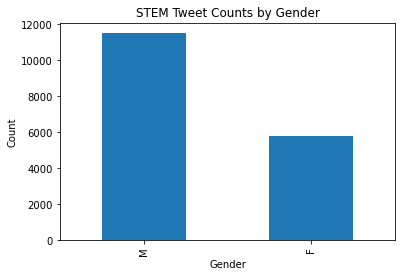

In [16]:
# Count tweets about women vs men
print("Percentage of STEM Tweets by gender")
counts = tweets_df['Gender'].value_counts(normalize=True)
print(counts)
print()
print("Count of STEM Tweets by gender")
counts = tweets_df['Gender'].value_counts()
print(counts)
print()
print("Total Tweets:", len(tweets_df))
tweets_df.Gender.value_counts().plot(kind = 'bar')
plt.title('STEM Tweet Counts by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


## Gender prediction using unbalanced dataset

In [17]:
tweets_df = pd.read_csv("tweets_df.csv", dtype=object)

In [18]:
tweets_df.head()

,Handle,Text,Text_Token,Gender,Topic
0,@AngiMaryssa,Blackwell is great As a lawyer you have to bec...,"['blackwell', 'great', 'lawyer', 'become', 'ex...",M,science
1,@thiccbb69,math dumb af if ymxb then ytf dont she love me,"['math', 'dumb', 'af', 'ymxb', 'ytf', 'dont', ...",F,mathematics
2,@JaredEHalpern,Wow he was a hell of an engineer Grant Imahara...,"['wow', 'hell', 'engineer', 'grant', 'imahara'...",M,engineering
3,@BobBrigham,Matt Kelley is so bad he thinks coronavirus is...,"['matt', 'kelley', 'bad', 'think', 'coronaviru...",M,science
4,@vomit_bestie,that math test i just took was my absolute bit...,"['math', 'test', 'took', 'absolute', 'bitch', ...",F,mathematics


## Website/data copyright considerations
### Even though Tweets are protected under copyright, this is an academic exercise and, as such, scraping Tweet data from Twitter does not violate copyright laws.
